In [1]:
import numpy as np
import scipy.stats as ss

In [2]:
LAMBDA = 100
N_OBS = 10
CONFIDENCE = 0.99

TRUE_DIST = ss.poisson(LAMBDA)
OBS = TRUE_DIST.rvs(size=N_OBS)
MAX_OBS = max(OBS)

# choose uniformative priors for the gamma distribution
ALPHA_PRIOR = 1e-3
BETA_PRIOR = 1e-3

In [3]:
OBS

array([101, 122,  89, 108,  91,  96, 100, 106,  85,  95])

## samle from posterior and compare to true distribution

In [4]:
N_POSTERIOR_SAMPLES = 1000

In [5]:
# update priors based on observations
ALPHA_POST = ALPHA_PRIOR + sum(OBS)
BETA_POST = BETA_PRIOR + len(OBS)

In [6]:
lam = ss.gamma.median(ALPHA_POST, scale=1/BETA_POST)
posterior = ss.poisson(lam)

In [7]:
posterior_samples = posterior.rvs(size=N_POSTERIOR_SAMPLES)
true_dist_samples = TRUE_DIST.rvs(size=N_POSTERIOR_SAMPLES)

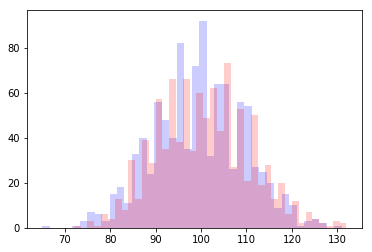

In [8]:
import matplotlib.pyplot as plt
_ = plt.hist(posterior_samples, bins=40, color='b', alpha=0.2)
_ = plt.hist(true_dist_samples, bins=40, color='r', alpha=0.2)

## get max estimate from cdf

In [9]:
import scipy.stats as ss
def estimate_max(dist, limit):
    return dist.ppf(limit)

In [10]:
MAX_EST = estimate_max(posterior, CONFIDENCE)
MAX_EST

123.0

In [11]:
# how many samples are actually less than our max estimate
sum(x < MAX_EST for x in posterior_samples) / len(posterior_samples)

0

In [12]:
# is our estimate bigger than the max?
MAX_EST - MAX_OBS

1.0

# Online learning

In [13]:
class Model:
    def __init__(self, alpha, beta, confidence):
        self.alpha = alpha
        self.beta = beta
        self.confidence = confidence
        
    def predict(self):
        return ss.poisson.ppf(self.confidence, self.lambda_)
        
    def update(self, observation):
        self.alpha += observation
        self.beta += 1
        
    @property
    def lambda_(self):
        return ss.gamma.median(self.alpha, scale=1/self.beta)

In [14]:
TRIAL_LENGTH = 1000
model = Model(ALPHA_POST, BETA_POST, CONFIDENCE)
observations = TRUE_DIST.rvs(size=TRIAL_LENGTH)
predictions = []
for observation in observations:
    model.update(observation)
    predictions.append(model.predict())

In [15]:
"""
==================
Animated histogram
==================

This example shows how to use a path patch to draw a bunch of
rectangles for an animated histogram.

"""
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path
import matplotlib.animation as animation

def visualize_learning(observations, predictions, cum_max=None):
    fig, ax = plt.subplots()

    # histogram our data with numpy
    n, bins = np.histogram(observations, 40)

    # get the corners of the rectangles for the histogram
    left = np.array(bins[:-1])
    right = np.array(bins[1:])
    bottom = np.zeros(len(left))
    top = bottom + n
    nrects = len(left)

    # here comes the tricky part -- we have to set up the vertex and path
    # codes arrays using moveto, lineto and closepoly

    # for each rect: 1 for the MOVETO, 3 for the LINETO, 1 for the
    # CLOSEPOLY; the vert for the closepoly is ignored but we still need
    # it to keep the codes aligned with the vertices
    nverts = nrects*(1 + 3 + 1)
    verts = np.zeros((nverts, 2))
    codes = np.ones(nverts, int) * path.Path.LINETO
    codes[0::5] = path.Path.MOVETO
    codes[4::5] = path.Path.CLOSEPOLY
    verts[0::5, 0] = left
    verts[0::5, 1] = bottom
    verts[1::5, 0] = left
    verts[1::5, 1] = top
    verts[2::5, 0] = right
    verts[2::5, 1] = top
    verts[3::5, 0] = right
    verts[3::5, 1] = bottom

    barpath = path.Path(verts, codes)
    patch = patches.PathPatch(
        barpath, facecolor='green', edgecolor='yellow', alpha=0.5)
    ax.add_patch(patch)

    ax.set_xlim(left[0], right[-1])
    ax.set_ylim(bottom.min(), top.max())

    def animate(i):
        n, bins = np.histogram(observations[:i], 40)
        top = bottom + n
        verts[1::5, 1] = top
        verts[2::5, 1] = top
        for line in ax.get_lines():
            line.remove()
        ax.axvline(predictions[i], color='r')
        if cum_max is not None:
            ax.axvline(cum_max[i], color='b')
        plt.title(i+1, x=1.05, y=0.5)
        return [patch, ]

    ani = animation.FuncAnimation(fig, animate, len(observations),
                                  repeat=False, blit=True, interval=30)
    return ani

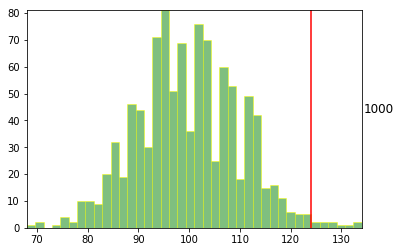

In [16]:
from IPython.display import HTML
ani = visualize_learning(observations, predictions)
HTML(ani.to_html5_video())

# online training with moving distribution

In [15]:
import itertools
model = Model(1e-3, 1e-3, CONFIDENCE)
lambdas = list(reversed(range(80, 110, 5)))
lambdas += list(range(85, 110, 5))
true_dists = [ss.poisson(L) for L in lambdas for _ in range(100)]
observations = np.array([d.rvs() for d in true_dists])
predictions = []
model_params = []
for observation in observations:
    model.update(observation)
    model_params.append((
        ss.gamma(model.alpha, scale=1/model.beta),
        ss.poisson(model.lambda_)))
    predictions.append(model.predict())

In [28]:
"""
==================
Animated histogram
==================

This example shows how to use a path patch to draw a bunch of
rectangles for an animated histogram.

"""
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path
import matplotlib.animation as animation


TITLE_TEMPLATE = '{n}\n{pct:0.2f}\n{pred}\n{max}'


class Histogram:
    def __init__(self, ax, arr):
        self.ax = ax
        self.init_hist(self.ax, arr)

    def init_hist(self, ax, arr):
        n, bins = np.histogram(arr, 40)

        # get the corners of the rectangles for the histogram
        left = np.array(bins[:-1])
        right = np.array(bins[1:])
        bottom = np.zeros(len(left))
        top = bottom + n
        nrects = len(left)

        # here comes the tricky part -- we have to set up the vertex and path
        # codes arrays using moveto, lineto and closepoly

        # for each rect: 1 for the MOVETO, 3 for the LINETO, 1 for the
        # CLOSEPOLY; the vert for the closepoly is ignored but we still need
        # it to keep the codes aligned with the vertices
        nverts = nrects*(1 + 3 + 1)
        verts = np.zeros((nverts, 2))
        codes = np.ones(nverts, int) * path.Path.LINETO
        codes[0::5] = path.Path.MOVETO
        codes[4::5] = path.Path.CLOSEPOLY
        verts[0::5, 0] = left
        verts[0::5, 1] = bottom
        verts[1::5, 0] = left
        verts[1::5, 1] = top
        verts[2::5, 0] = right
        verts[2::5, 1] = top
        verts[3::5, 0] = right
        verts[3::5, 1] = bottom

        barpath = path.Path(verts, codes)
        patch = patches.PathPatch(barpath, alpha=0.5)
        ax.add_patch(patch)

        ax.set_xlim(left[0], right[-1])
        ax.set_ylim(bottom.min(), top.max())
        
        self.verts = verts
        self.top = top
        self.bottom = bottom
        self.patch = patch

    def update(self, arr):
        n, bins = np.histogram(arr, 40)
        top = self.bottom + n
        self.verts[1::5, 1] = top
        self.verts[2::5, 1] = top
        
    def clear_lines(self):
        for line in self.ax.get_lines():
            line.remove()     
        
    def plot_line(self, x, color, label):
        self.ax.axvline(x, color=color, label=label)

def visualize_learning(observations, predictions, model_params, true_dists, last_n=None):
    plt.style.use('seaborn')
    fig = plt.figure(figsize=(10, 6))
    ax_obs = plt.subplot2grid((3, 6), (0, 0), rowspan=3, colspan=4)
    ax_true = plt.subplot2grid((3, 6), (0, 4), colspan=2)
    ax_lam = plt.subplot2grid((3, 6), (1, 4), colspan=2, sharex=ax_true)
    ax_gamma = plt.subplot2grid((3, 6), (2, 4), colspan=2)
    
    ax_obs.set_title('observations')
    ax_true.set_title('generating distribution')
    ax_lam.set_title('lambda posterior')
    ax_gamma.set_title('gamma posterior')
    
    plt.tight_layout()

    if last_n is None:
        last_n = len(observations)
    obs_hist = Histogram(ax_obs, observations[:3*last_n])
    true_hist = Histogram(ax_true, true_dists[0].rvs(size=1000))
    poisson_hist = Histogram(ax_lam, model_params[0][1].rvs(size=1000))
    gamma_hist = Histogram(ax_gamma, model_params[0][0].rvs(size=1000))

    def animate(i):
        start = 0 if i < last_n else i - last_n
        stop = i
        obs = observations[start:stop+1]
        obs_hist.update(obs)
        
        true = true_dists[i]
        gamma, poisson = model_params[i]
        gamma_hist.update(gamma.rvs(size=1000))
        poisson_hist.update(poisson.rvs(size=1000))
        true_hist.update(true.rvs(size=1000))

        pred = predictions[i]
        true_max_with_confidence = estimate_max(true, CONFIDENCE)
        obs_hist.clear_lines()
        obs_hist.plot_line(pred, color='r', label='true')
        obs_hist.plot_line(true_max_with_confidence, color='b', label='prediction')

        title = TITLE_TEMPLATE.format(
            n=(i+1),
            pct=((obs < pred).sum() / len(obs)),
            pred=pred,
            max=max(obs))
        plt.title(title, x=1.1, y=0.6)
        return [obs_hist.patch, gamma_hist.patch, poisson_hist.patch]

    ani = animation.FuncAnimation(fig, animate, len(observations),
                                  repeat=False, blit=True, interval=100)
    return ani

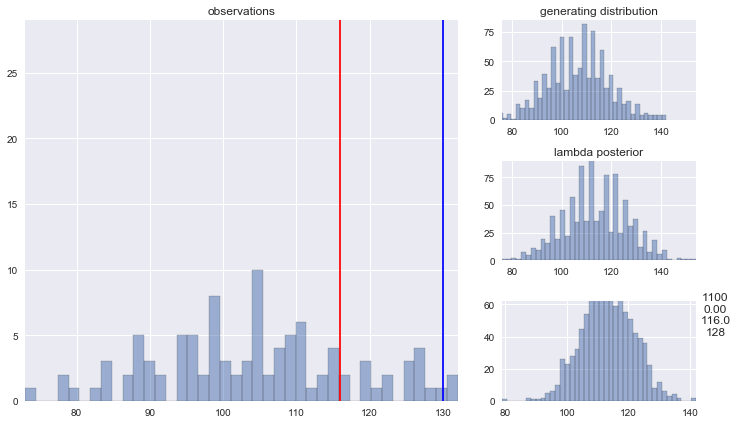

In [29]:
from IPython.display import HTML
ani = visualize_learning(
    observations,
    predictions,
    model_params,
    true_dists,
    last_n=100)
HTML(ani.to_html5_video())